<h1 style='color:red;font-size:40px'> PCR(classification) </h1>

> This notebook contains analysis and modeling to predict PCR of breast cancer patients

## Importing required packages

In [153]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score, mean_absolute_error, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import f_classif
import numpy as np
from scipy import stats as st
from sklearn.preprocessing import PowerTransformer
import warnings
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer


import tensorflow as tf
from tensorflow import keras

In [136]:
import warnings
warnings.filterwarnings("ignore")

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
pd.set_option('display.max_columns', None)


## Reading the Data

In [15]:
df = pd.read_excel(r"data/trainDataset.xls")

In [16]:
df.head()

,ID,pCR (outcome),RelapseFreeSurvival (outcome),Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,HistologyType,LNStatus,TumourStage,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceAverage,original_glcm_DifferenceEntropy,original_glcm_DifferenceVariance,original_glcm_Id,original_glcm_Idm,original_glcm_Idmn,original_glcm_Idn,original_glcm_Imc1,original_glcm_Imc2,original_glcm_InverseVariance,original_glcm_JointAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_MCC,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glcm_SumSquares,original_gldm_DependenceEntropy,original_gldm_DependenceNonUniformity,original_gldm_DependenceNonUniformityNormalized,original_gldm_DependenceVariance,original_gldm_GrayLevelNonUniformity,original_gldm_GrayLevelVariance,original_gldm_HighGrayLevelEmphasis,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_GrayLevelNonUniformityNormalized,original_glrlm_GrayLevelVariance,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_RunEntropy,original_glrlm_RunLengthNonUniformity,original_glrlm_RunLengthNonUniformityNormalized,original_glrlm_RunPercentage,original_glrlm_RunVariance,original_glrlm_ShortRunEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glszm_GrayLevelNonUniformity,original_glszm_GrayLevelNonUniformityNormalized,original_glszm_GrayLevelVariance,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_LargeAreaEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,TRG002174,1,144.0,41.0,0,0,0,1,3,3,1,1,2,0.813912,0.724080,23.781937,32.844370,37.696154,38.626416,34.713110,39.572718,14209.458330,26.732440,0.771675,3676.500012,0.258736,14263,-0.163500,0.708860,2897.68930,0.738088,0.406537,4.594629,2.114799,0.278008,0.248168,0.217628,-1.251833,3.366632,0.174026,0.450734,0.386237,2897.68930,0.670

### Target Label counts

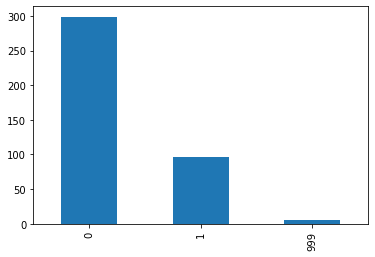

In [17]:
df['pCR (outcome)'].value_counts().plot(kind='bar')
plt.show()

### Targel Label Count Values

In [18]:
df['pCR (outcome)'].value_counts()

0      299
1       96
999      5
Name: pCR (outcome), dtype: int64

### Targel Label Counts Percentages

In [19]:
df['pCR (outcome)'].value_counts()/df['pCR (outcome)'].shape[0]

0      0.7475
1      0.2400
999    0.0125
Name: pCR (outcome), dtype: float64

## Taking only `pCR (outcome)` 0 and 1

In [20]:
df = df[df['pCR (outcome)']!=999]

### Replacing 999 values with Mode

- Fallowed manual replacing for EDA purpose, later used sklearn methods in final pipeline for best model

In [21]:
df.replace({999:None}).isnull().sum().sort_values(ascending=False).head(10)

HistologyType                                         3
ChemoGrade                                            3
Proliferation                                         2
PgR                                                   1
HER2                                                  1
TrippleNegative                                       1
LNStatus                                              1
original_glrlm_GrayLevelVariance                      0
original_gldm_SmallDependenceEmphasis                 0
original_gldm_SmallDependenceHighGrayLevelEmphasis    0
dtype: int64

In [22]:
df['HistologyType'] = df['HistologyType'].replace({999:None}).fillna(int(df['HistologyType'].mode()))
df['ChemoGrade'] = df['ChemoGrade'].replace({999:None}).fillna(int(df['ChemoGrade'].mode()))
df['Proliferation'] = df['Proliferation'].replace({999:None}).fillna(int(df['Proliferation'].mode()))
df['PgR'] = df['PgR'].replace({999:None}).fillna(int(df['PgR'].mode()))
df['HER2'] = df['HER2'].replace({999:None}).fillna(int(df['HER2'].mode()))
df['TrippleNegative'] = df['TrippleNegative'].replace({999:None}).fillna(int(df['TrippleNegative'].mode()))
df['LNStatus'] = df['LNStatus'].replace({999:None}).fillna(int(df['LNStatus'].mode()))

## Exploring importance of different features

#### Age

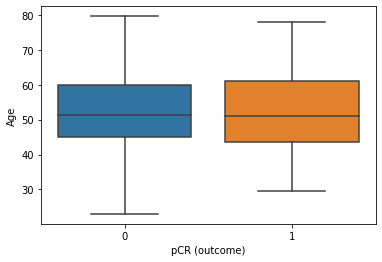

In [23]:
sns.boxplot(y='Age', x='pCR (outcome)',data=df)
plt.show()

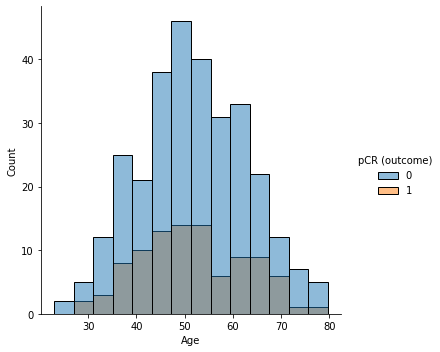

In [24]:
### Age distribution
sns.displot(x=df['Age'],hue=df['pCR (outcome)'])
plt.show()

### T- test to find out significance of `Age` on `pCR outcome`

In [25]:

st.ttest_1samp(a=df[df['pCR (outcome)']==0]['Age'].to_list(),popmean=df['Age'].mean())

Ttest_1sampResult(statistic=-0.005236279523801493, pvalue=0.9958255760644659)

In [26]:

st.ttest_1samp(a=df[df['pCR (outcome)']==1]['Age'].to_list(),popmean=df['Age'].mean())

Ttest_1sampResult(statistic=0.009385560849441685, pvalue=0.9925311972673878)

### Conclusion:

>**`Age` is not signofocant feature on 'pCR (outcome)'** for 10% critical value

### Selecting Categorical variables

- Each categorical variable is tested against `pCR (outcome)` using **chi-square test**
- If the varience created by the categorical variable is greater than $\alpha=0.1$ then it is selected
- Variance of categorical variable also analysed visually by plotting success rate of pCR (outcome) against every variable 

### Statistical analysis of categorical variables

In [27]:
def chiaSquare2(var1, var2 , df):
    #print(f"var1:{var1}")
    #print(f"var2:{var2}")
    tmp = df.groupby([var1, var2],as_index=False).agg({'ID':'count'}).rename(columns={'ID':'count'})
    var1_cats = list(df[var1].unique())
    var1_cats.sort()
    #print(f"var1 categories: {var1_cats}")
    
    pcr_cats = list(df[var2].unique())
    pcr_cats.sort()
    #print(f"var2 categories: {pcr_cats}")    
    
    observed = []  
    
    for pcr_cat in pcr_cats:
        observed.append( tmp[tmp['pCR (outcome)']==pcr_cat]['count'].to_list() )
        
    #print(f"observed: {observed}")        
    stat, p, dof, expected = st.chi2_contingency(observed)    

    return stat, p, dof, list(expected)

In [28]:
cols = ['ER','PgR','HER2','TrippleNegative','ChemoGrade','Proliferation','HistologyType',
        'LNStatus','TumourStage']
alpha = 0.1
significant_categorical_cols = []


for col in cols:
    stat, p, dof, expected = chiaSquare2(col,'pCR (outcome)',df)     
    if p < alpha:
        status = 'significant'
        significant_categorical_cols.append(col)
    else:
        status='Not significant'
    print(f"{col}: {status}")
    print(f"P-Value: {p}")    
    print("\n")
print(significant_categorical_cols)

ER: significant
P-Value: 1.3125384834156194e-05


PgR: significant
P-Value: 4.1190801418336374e-05


HER2: significant
P-Value: 1.1389735121621171e-05


TrippleNegative: Not significant
P-Value: 0.15831013145498024


ChemoGrade: significant
P-Value: 0.0957964916831371


Proliferation: significant
P-Value: 0.007028022910869786


HistologyType: Not significant
P-Value: 0.1900770113619007


LNStatus: significant
P-Value: 0.003168748627998413


TumourStage: significant
P-Value: 0.066318188061944


['ER', 'PgR', 'HER2', 'ChemoGrade', 'Proliferation', 'LNStatus', 'TumourStage']


## Visual analysis of categorical variables

> - On every plot orange dotted line indicated average `pCR (outcome)` successrate
> - Each bar represents `pCR (outcome)` successrate with in that category

#### ER

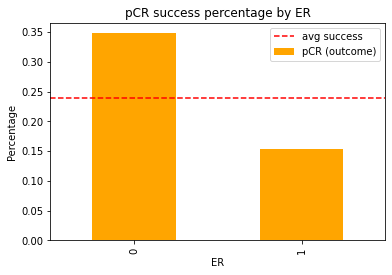

In [105]:
df.groupby('ER',as_index=False).mean()['pCR (outcome)'].plot(kind='bar',color='orange')
plt.axhline(y = 0.24, color = 'r', linestyle = '--', label='avg success')
plt.title("pCR success percentage by ER")
plt.xlabel("ER")
plt.ylabel("Percentage")
plt.legend()
plt.show()

#### PgR

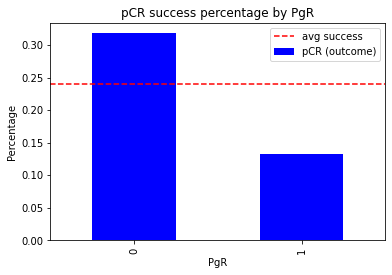

In [106]:
df.groupby('PgR',as_index=False).mean()['pCR (outcome)'].plot(kind='bar',color='blue')
plt.axhline(y = 0.24, color = 'r', linestyle = '--', label='avg success')
plt.title("pCR success percentage by PgR")
plt.xlabel("PgR")
plt.ylabel("Percentage")
plt.legend()
plt.show()

#### HER2

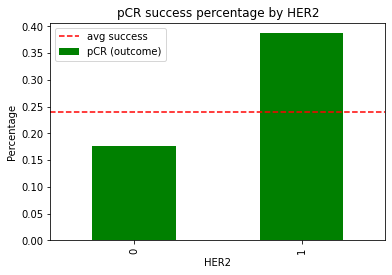

In [107]:
df.groupby('HER2',as_index=False).mean()['pCR (outcome)'].plot(kind='bar',color='green')
plt.axhline(y = 0.24, color = 'r', linestyle = '--', label='avg success')
plt.title("pCR success percentage by HER2")
plt.xlabel("HER2")
plt.ylabel("Percentage")
plt.legend()
plt.show()

#### TrippleNegative

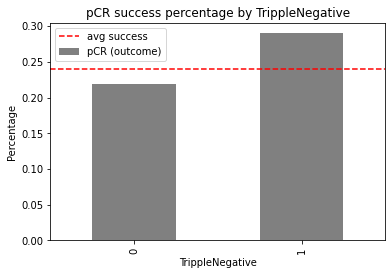

In [108]:
df.groupby('TrippleNegative',as_index=False).mean()['pCR (outcome)'].plot(kind='bar',color='grey')
plt.axhline(y = 0.24, color = 'r', linestyle = '--', label='avg success')
plt.title("pCR success percentage by TrippleNegative")
plt.xlabel("TrippleNegative")
plt.ylabel("Percentage")
plt.legend()
plt.show()

#### ChemoGrade

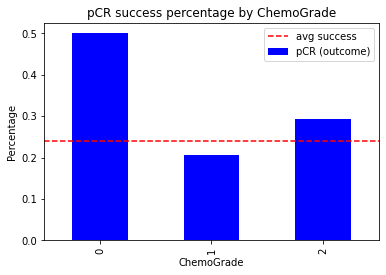

In [109]:
df.groupby('ChemoGrade',as_index=False).mean()['pCR (outcome)'].plot(kind='bar',color='blue')
plt.axhline(y = 0.24, color = 'r', linestyle = '--', label='avg success')
plt.title("pCR success percentage by ChemoGrade")
plt.xlabel("ChemoGrade")
plt.ylabel("Percentage")
plt.legend()
plt.show()

#### Proliferation

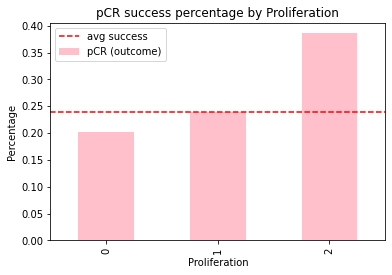

In [110]:
df.groupby('Proliferation',as_index=False).mean()['pCR (outcome)'].plot(kind='bar',color='pink')
plt.axhline(y = 0.24, color = 'r', linestyle = '--', label='avg success')
plt.title("pCR success percentage by Proliferation")
plt.xlabel("Proliferation")
plt.ylabel("Percentage")
plt.legend()
plt.show()

#### HistologyType

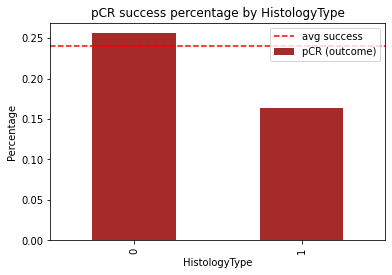

In [111]:
df.groupby('HistologyType',as_index=False).mean()['pCR (outcome)'].plot(kind='bar',color='brown')
plt.axhline(y = 0.24, color = 'r', linestyle = '--', label='avg success')
plt.title("pCR success percentage by HistologyType")
plt.xlabel("HistologyType")
plt.ylabel("Percentage")
plt.legend()
plt.show()

#### LNStatus

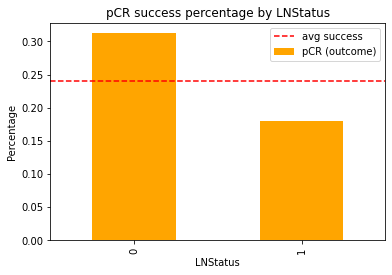

In [112]:
df.groupby('LNStatus',as_index=False).mean()['pCR (outcome)'].plot(kind='bar',color='orange')
plt.axhline(y = 0.24, color = 'r', linestyle = '--', label='avg success')
plt.title("pCR success percentage by LNStatus")
plt.xlabel("LNStatus")
plt.ylabel("Percentage")
plt.legend()
plt.show()

#### TumourStage

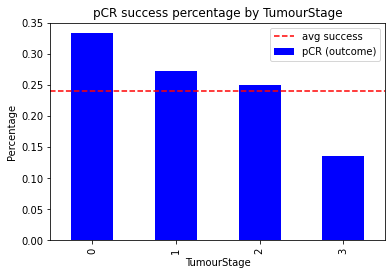

In [113]:
df.groupby('TumourStage',as_index=False).mean()['pCR (outcome)'].plot(kind='bar',color='blue')
plt.axhline(y = 0.24, color = 'r', linestyle = '--', label='avg success')
plt.title("pCR success percentage by TumourStage")
plt.xlabel("TumourStage")
plt.ylabel("Percentage")
plt.legend()
plt.show()

### Conclusion

- From visual inspection we can see that `pCR (outcome)` success rate for many categories is either above or below the average success rate considerablly.
- Even statistically same features exibited sigiificant varience with respecive to `pCR (outcome)`

**Selected variables based on 10% critical value**


- ER, PgR, HER2, LNStatus, TumourStage, Proliferation, ChemoGrade, HistologyType


## Continuous variables

In [29]:
float_cols = list(df.select_dtypes(include='float64').columns)
float_cols.remove('RelapseFreeSurvival (outcome)')
float_cols.remove('Age')

In [30]:
def find_boundaries(df, variable, distance=1.5):
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
    lower_boundary = df[variable].quantile(0.25) - (IQR * 1.5)
    upper_boundary = df[variable].quantile(0.75) + (IQR * 1.5)
    return lower_boundary, upper_boundary
    

In [31]:
def treat_outliers(df, variable, distance=1.5, inplace=True):
    """ 
    Fill outliers with mean
    
    upper_boundary = 75th qualtile + (IQR * diatance)
    upper_boundary = 25th qualtile - (IQR * diatance)
        
    """
    
    lower_boundary, upper_boundary = find_boundaries(df,variable)
    if inplace:
        df[variable] = np.where(df[variable]>upper_boundary,df[variable].mean(),
                                np.where(df[variable]<lower_boundary,df[variable].mean(),df[variable])
                           )
    else:
        return np.where(df[variable]>upper_boundary,df[variable].mean(),
                                np.where(df[variable]<lower_boundary,df[variable].mean(),df[variable])
                           )

### Removign outliers & skewness  for all continuous features

In [32]:
skewness=[]
for col in float_cols:
    treat_outliers(df, col, inplace=True)
    skewness.append((col,df[col].skew()))
    

## skewness before treating

In [33]:
skewness_df = pd.DataFrame(skewness,columns=['feature','skewness_score'])
skewness_df.sort_values(by='skewness_score',ascending=False,inplace=True)


#### Plotting varibales skewness distribution

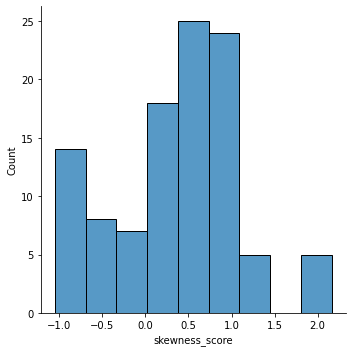

In [119]:
sns.displot(x=skewness_df['skewness_score'])
plt.show()

## Treating Skewness

> For many statistical tests and models normality is the common requirement.
> Fetures in this data contains both positive and negative values so using 
**Performing Yoe-Johnson transformation to transfom the features**

In [34]:
transformer = PowerTransformer(method='yeo-johnson')
transformer.fit(df[float_cols])
df_float_cols = pd.DataFrame(transformer.transform(df[float_cols]),columns=float_cols)

C:\Users\chaitanyamanem\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [36]:
post_skewness = []
for col in float_cols:
    post_skewness.append((col,df_float_cols[col].skew()))
        
post_skewness_df = pd.DataFrame(post_skewness,columns=['feature','skewness_score'])
post_skewness_df.sort_values(by='skewness_score',ascending=False,inplace=True)


#### Plotting varibales skewness distribution after treatment

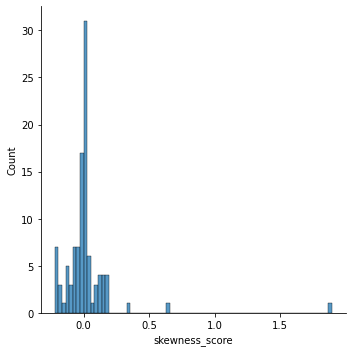

In [38]:
sns.displot(x=post_skewness_df['skewness_score'])
plt.show()

#### Taking features only with in skewness range -0.5 to 0.5

In [39]:
transformed_float_cols = post_skewness_df[(post_skewness_df['skewness_score']>-0.5) & (post_skewness_df['skewness_score']<0.5)]['feature'].to_list()
df_float_cols = df_float_cols[transformed_float_cols]


## pointbiserialr correlation 


> Used `pointbiserialr correlation` as a metric to identify the relation between continuous features and 'pCR (outcome)' as this good in spotting both liner and non linear relationships

In [40]:
correlation = []

for col in list(df_float_cols.columns):
    correlation.append((col,abs(st.pointbiserialr(df['pCR (outcome)'],df_float_cols[col]).correlation)))



C:\Users\chaitanyamanem\anaconda3\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [41]:
float_cols_correlation_df = pd.DataFrame(correlation,columns=['feature','correlation'])
float_cols_correlation_df.sort_values(by='correlation',ascending=False,inplace=True)


### Plotting correlation distribution of the features

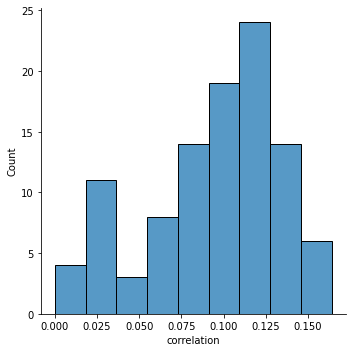

In [43]:
sns.displot(x=float_cols_correlation_df['correlation'])
plt.show()

### Selecting continuous features having correlation greater than 0.12

In [44]:
final_selected_float_cols = float_cols_correlation_df[abs(float_cols_correlation_df['correlation'])>0.12]['feature'].to_list()

final_continuous_features_df = df_float_cols[final_selected_float_cols]
final_continuous_features_df.head(3)

,original_glrlm_RunPercentage,original_glrlm_LongRunLowGrayLevelEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_glrlm_RunLengthNonUniformityNormalized,original_gldm_LargeDependenceEmphasis,original_glrlm_RunEntropy,original_glrlm_LongRunEmphasis,original_gldm_DependenceEntropy,original_glrlm_RunVariance,original_ngtdm_Contrast,original_firstorder_TotalEnergy,original_firstorder_Energy,original_glrlm_LongRunHighGrayLevelEmphasis,original_glcm_MaximumProbability,original_firstorder_10Percentile,original_firstorder_Uniformity,original_ngtdm_Complexity,original_gldm_GrayLevelVariance,original_shape_Maximum2DDiameterSlice,original_gldm_DependenceNonUniformity,original_shape_SurfaceArea,original_glcm_ClusterProminence,original_glcm_SumSquares,original_glrlm_GrayLevelNonUniformity,original_shape_MeshVolume,original_firstorder_Entropy
0,1.809329,-1.001900,-2.014558,1.457461,-1.830925,-0.234121,-1.143650,2.300923,-0.627258,0.815584,-1.822729,-1.822729,-1.041581,-0.378908,-1.104284,-1.813786,2.139064,1.797994,-0.384940,-0.752055,-0.153263,1.693400,0.394809,0.508749,0.244211,1.689474
1,-0.865203,0.827094,1.001130,-0.813269,0.905911,0.780899,0.939034,-0.988042,0.844573,-0.701162,0.254132,0.254132,0.982890,0.578373,0.708810,0.528056,-0.419685,-0.515554,-0.278365,0.515459,0.177768,-0.755105,-0.612923,0.052605,0.243604,-0.441471
2,-0.864054,0.642440,0.965911,-0.969414,0.864701,0.719790,0.754650,-0.850452,0.557812,-0.920492,-0.460947,-0.460947,0.800122,0.819227,0.653180,0.767834,-0.662098,-0.760606,0.069737,0.170217,-0.075719,-0.983948,-0.851830,-0.166883,-0.085127,-0.687221


#### Final shape of the data selected

In [46]:
final_continuous_features_df.shape

(395, 26)

### Merging categorical can continuous features

In [47]:
X = pd.concat([final_continuous_features_df.reset_index(),df[significant_categorical_cols].reset_index()],axis=1)
y = df['pCR (outcome)']
X.drop(columns=['index'],inplace=True)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42,stratify=y)

### Scaling the data

In [49]:
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

## Logistic Regression

In [136]:
lr = LogisticRegression(max_iter=300)
lr.fit(X_train,y_train)
y_predicted = lr.predict(X_test)

Accuracy: 0.758
Precission: 0.5
Recall: 0.083
f1_score: 0.143


Text(0.5, 24.0, 'Predicted label')

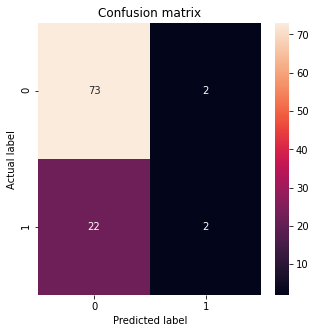

In [160]:
print(f"Accuracy: {round(accuracy_score(y_test,y_predicted),3)}")
#print(f"Confusion matrix: \n{confusion_matrix(y_test,y_predicted)}")
print(f"Precission: {round(precision_score(y_test,y_predicted),3)}")
print(f"Recall: {round(recall_score(y_test,y_predicted),3)}")
print(f"f1_score: {round(f1_score(y_test,y_predicted),3)}")

cm = confusion_matrix(y_test,y_predicted)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## Weighted Logistic Regression

In [76]:
parameters = {
    'class_weight':[{0:1,1:1},{0:1.15,1:1},{0:1.25,1:1},{0:1,1:2.5},{0:1,1:5},{0:1,1:10},{0:1,1:30},{0:1,1:40},{0:1,1:50},
                    {0:1,1:70},{0:1,1:80},{0:1,1:100},
                    {0:5,1:1},{0:10,1:1},{0:30,1:1},{0:40,1:1},{0:50,1:1},
                    {0:70,1:1},{0:0.8,1:1},{0:0.5,1:0.5},
                    {0:0.6,1:0.5},{0:0.5,1:0.6},{0:0.4,1:0.7},{0:0.3,1:0.7}
                   ]
}
wlr = LogisticRegression(max_iter=300)

In [77]:
grid = GridSearchCV(wlr,parameters,scoring="recall", cv=3, n_jobs=3)
grid.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=300), n_jobs=3,
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1.15, 1: 1},
                                          {0: 1.25, 1: 1}, {0: 1, 1: 2.5},
                                          {0: 1, 1: 5}, {0: 1, 1: 10},
                                          {0: 1, 1: 30}, {0: 1, 1: 40},
                                          {0: 1, 1: 50}, {0: 1, 1: 70},
                                          {0: 1, 1: 80}, {0: 1, 1: 100},
                                          {0: 5, 1: 1}, {0: 10, 1: 1},
                                          {0: 30, 1: 1}, {0: 40, 1: 1},
                                          {0: 50, 1: 1}, {0: 70, 1: 1},
                                          {0: 0.8, 1: 1}, {0: 0.5, 1: 0.5},
                                          {0: 0.6, 1: 0.5}, {0: 0.5, 1: 0.6},
                                          {0: 0.4, 1: 0.7}, {0: 0.3, 1: 0.7}]},
             scoring='recall')

In [78]:
print(f"Grid best parameters:{grid.best_params_}")

Grid best parameters:{'class_weight': {0: 1, 1: 100}}


In [79]:
wlr = LogisticRegression(class_weight={0: 1, 1: 100},max_iter=300)
wlr.fit(X_train,y_train)
y_predicted = wlr.predict(X_test)

## Finetuning threshold to find optimum `Recall`

In [80]:
test_prediction_probs = wlr.predict_proba(X_test)
test_prediction_probs = test_prediction_probs[:,1]

In [81]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test,test_prediction_probs)

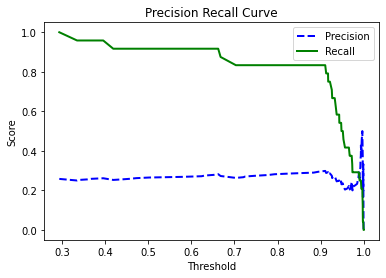

In [82]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
#plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
#[...]  # beautify the figure: add grid, legend, axis, labels, and circles
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title("Precision Recall Curve")
plt.legend()
plt.show()

In [98]:
threshold = 0.65 ## Identified from above grapfh and lttle more analysis to zoom in the numbers
custom_test_prediction = np.where(test_prediction_probs>threshold,1,0)

Accuracy: 0.40404040404040403
Precission: 0.27848101265822783
Recall: 0.9166666666666666
f1_score: 0.42718446601941745


Text(0.5, 24.0, 'Predicted label')

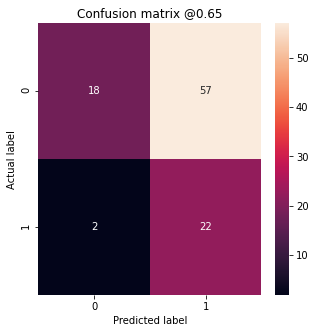

In [99]:
print(f"Accuracy: {accuracy_score(y_test,custom_test_prediction)}")
print(f"Precission: {precision_score(y_test,custom_test_prediction)}")
print(f"Recall: {recall_score(y_test,custom_test_prediction)}")
print(f"f1_score: {f1_score(y_test,custom_test_prediction)}")

#print(f"Confusion matrix: \n{confusion_matrix(y_test,custom_test_prediction)}")

cm = confusion_matrix(y_test,custom_test_prediction)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix @{:.2f}'.format(threshold))
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### With SMOTE

In [87]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

### After oversampling, data shape

In [88]:
X_res.shape, y_res.shape

((448, 33), (448,))

#### Logistic regression on SMOTE

In [89]:
lrsmote = LogisticRegression(max_iter=300)
lrsmote.fit(X_res, y_res)
y_predicted = lrsmote.predict(X_test)


Accuracy: 0.535
Precission: 0.238
Recall: 0.417
f1_score: 0.303


Text(0.5, 24.0, 'Predicted label')

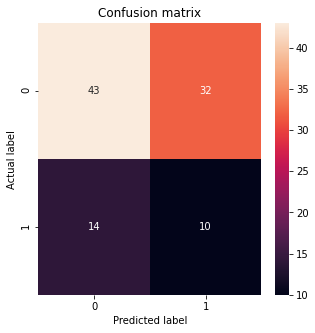

In [90]:
print(f"Accuracy: {round(accuracy_score(y_test,y_predicted),3)}")
print(f"Precission: {round(precision_score(y_test,y_predicted),3)}")
print(f"Recall: {round(recall_score(y_test,y_predicted),3)}")
print(f"f1_score: {round(f1_score(y_test,y_predicted),3)}")


cm = confusion_matrix(y_test,y_predicted)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### KNN

In [156]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
params ={'n_neighbors':[1,2,3,7,10,17,20,25,27,35,50]}
knn_grid = GridSearchCV(knn,params,scoring='accuracy',cv=3)
knn_grid.fit(X_train[['original_glrlm_RunPercentage','original_ngtdm_Contrast']],y_train)
knn_grid.best_estimator_.fit(X_train[['original_glrlm_RunPercentage','original_ngtdm_Contrast']],y_train)
print(knn_grid.best_params_)

{'n_neighbors': 20}


Accuracy: 0.7575757575757576
Precission: 0.5
Recall: 0.08333333333333333
f1_score: 0.14285714285714285


Text(0.5, 24.0, 'Predicted label')

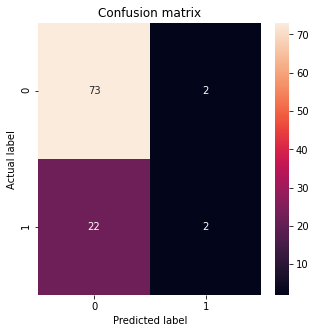

In [157]:
y_predicted = knn_grid.best_estimator_.predict(X_test[['original_glrlm_RunPercentage','original_ngtdm_Contrast']])
print(f"Accuracy: {accuracy_score(y_test,y_predicted)}")
#print(f"Confusion matrix: \n{confusion_matrix(y_test,y_predicted)}")
print(f"Precission: {precision_score(y_test,y_predicted)}")
print(f"Recall: {recall_score(y_test,y_predicted)}")
print(f"f1_score: {f1_score(y_test,y_predicted)}")


cm = confusion_matrix(y_test,y_predicted)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### RandomForest

In [168]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
y_predicted = rfc.predict(X_test)


In [169]:
print(f"Accuracy: {accuracy_score(y_test,y_predicted)}")
print(f"Confusion matrix: \n{confusion_matrix(y_test,y_predicted)}")
print(f"Precission: {precision_score(y_test,y_predicted)}")
print(f"Recall: {recall_score(y_test,y_predicted)}")
print(f"f1_score: {f1_score(y_test,y_predicted)}")

Accuracy: 0.7171717171717171
Confusion matrix: 
[[68  7]
 [21  3]]
Precission: 0.3
Recall: 0.125
f1_score: 0.17647058823529413


### Hyperparameter Tuning

In [171]:
params={
    'criterion':['entropy', 'gini'],
    'n_estimators':[70,100,200,300],
    'min_weight_fraction_leaf':[0.0, 0.0025, 0.005, 0.0075, 0.01, 0.05],
    'min_samples_split':[2, 0.01, 0.02, 0.03, 0.04, 0.06, 0.08, 0.1],
    'min_samples_leaf':[1,2,4,6,8,10,20,30],
    'min_impurity_decrease':[0.0, 0.01, 0.05, 0.10, 0.15, 0.2],
    'max_leaf_nodes':[10, 15, 20, 25, 30, 35, 40, 45, 50, None], 
    'max_features':['auto', 0.8, 0.7, 0.6, 0.5, 0.4],
    'max_depth':[None,2,4,6,8,10,20],
    'min_weight_fraction_leaf':[0.0, 0.0025, 0.005, 0.0075, 0.01, 0.05]
}

In [172]:
rfc = RandomForestClassifier(n_estimators=300)
rs = RandomizedSearchCV(rfc,params,scoring='accuracy',cv=3,n_jobs=3,n_iter=100)
rs.fit(X_train,y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(n_estimators=300),
                   n_iter=100, n_jobs=3,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [None, 2, 4, 6, 8, 10, 20],
                                        'max_features': ['auto', 0.8, 0.7, 0.6,
                                                         0.5, 0.4],
                                        'max_leaf_nodes': [10, 15, 20, 25, 30,
                                                           35, 40, 45, 50,
                                                           None],
                                        'min_impurity_decrease': [0.0, 0.01,
                                                                  0.05, 0.1,
                                                                  0.15, 0.2],
                                        'min_samples_leaf': [1, 2, 4, 6, 8, 10,
                                               

In [173]:
rs.best_params_

{'n_estimators': 70,
 'min_weight_fraction_leaf': 0.005,
 'min_samples_split': 0.06,
 'min_samples_leaf': 1,
 'min_impurity_decrease': 0.0,
 'max_leaf_nodes': 10,
 'max_features': 'auto',
 'max_depth': 8,
 'criterion': 'entropy'}

In [174]:
rs.best_score_

0.7601869030440459

Accuracy: 0.778
Precission: 0.667
Recall: 0.167
f1_score: 0.267


Text(0.5, 24.0, 'Predicted label')

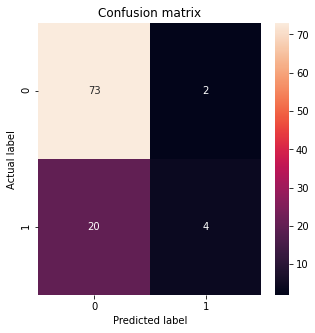

In [175]:
rs.best_estimator_.fit(X_train,y_train)
y_predicted = rs.best_estimator_.predict(X_test)
print(f"Accuracy: {round(accuracy_score(y_test,y_predicted),3)}")
#print(f"Confusion matrix: \n{confusion_matrix(y_test,y_predicted)}")
print(f"Precission: {round(precision_score(y_test,y_predicted),3)}")
print(f"Recall: {round(recall_score(y_test,y_predicted),3)}")
print(f"f1_score: {round(f1_score(y_test,y_predicted),3)}")


cm = confusion_matrix(y_test,y_predicted)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Gradient Boosting

In [101]:
from sklearn.ensemble import GradientBoostingClassifier


In [102]:
gbc = GradientBoostingClassifier()
params={
    'max_depth':[1,2,3],
    'subsample':[0.5,0.7,0.8],
    'n_estimators':[50,100,300,500],
    'learning_rate':[0.001,0.005,0.01,0.05, 0.1,]
}

### Best params

In [103]:
rand_gbc = RandomizedSearchCV(gbc, params, n_iter=20, scoring='accuracy', 
                              cv=5, n_jobs=3, random_state=2)
rand_gbc.fit(X_train,y_train)
rand_gbc.best_params_

{'subsample': 0.5, 'n_estimators': 50, 'max_depth': 2, 'learning_rate': 0.001}

### Best score

In [104]:
rand_gbc.best_score_

0.7567796610169492

Accuracy: 0.7575757575757576
Precission: 0.0
Recall: 0.0
f1_score: 0.0


C:\Users\chaitanyamanem\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 24.0, 'Predicted label')

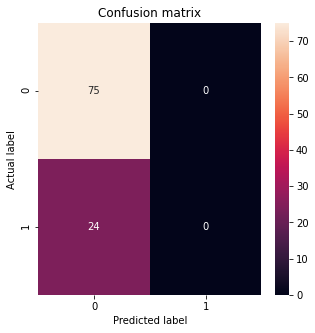

In [109]:
rand_gbc.best_estimator_.fit(X_train,y_train)
y_predicted = rand_gbc.best_estimator_.predict (X_test)
print(f"Accuracy: {accuracy_score(y_test,y_predicted)}")
#print(f"Confusion matrix: \n{confusion_matrix(y_test,y_predicted)}")
print(f"Precission: {precision_score(y_test,y_predicted)}")
print(f"Recall: {recall_score(y_test,y_predicted)}")
print(f"f1_score: {f1_score(y_test,y_predicted)}")

cm = confusion_matrix(y_test,y_predicted)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## XG Boost

#### Baseline XG boost mode

Accuracy: 0.696969696969697
Precission: 0.35
Recall: 0.2916666666666667
f1_score: 0.31818181818181823


Text(0.5, 24.0, 'Predicted label')

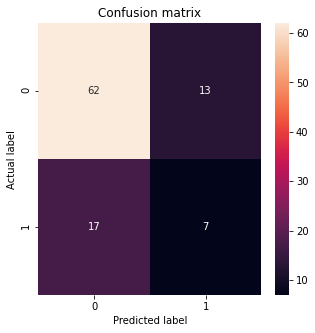

In [111]:
xgb_model = XGBClassifier(booster='gbtree', objective='binary:logistic', random_state=2)

xgb_model.fit(X_train,y_train)
y_predicted = xgb_model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test,y_predicted)}")
#print(f"Confusion matrix: \n{confusion_matrix(y_test,y_predicted)}")
print(f"Precission: {precision_score(y_test,y_predicted)}")
print(f"Recall: {recall_score(y_test,y_predicted)}")
print(f"f1_score: {f1_score(y_test,y_predicted)}")

cm = confusion_matrix(y_test,y_predicted)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Tuning hyperparamaeters for XGBoost

In [115]:
### Stratified k fold

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [125]:
def fit_params_test_score(params,scoring_metric):
    model = XGBClassifier(booster='gbtree', objective='binary:logistic', random_state=2)
    gs = RandomizedSearchCV(model,params,n_iter=50,scoring=scoring_metric,cv=kfold,n_jobs=3)
    gs.fit(X_train,y_train)
    
    gs.best_estimator_.fit(X_train,y_train)
    y_predicted = gs.best_estimator_.predict(X_test)
    
    print(f"best params: {gs.best_params_}")
    print("\n")
    print(f"best score: {gs.best_score_}")
    print("\n")
    print(f"Accuracy: {accuracy_score(y_test,y_predicted)}")
    #print(f"Confusion matrix: \n{confusion_matrix(y_test,y_predicted)}")
    print(f"Precission: {precision_score(y_test,y_predicted)}")
    print(f"Recall: {recall_score(y_test,y_predicted)}")
    print(f"f1_score: {f1_score(y_test,y_predicted)}")
    print(f"roc_auc_score: {roc_auc_score(y_test,y_predicted)}")
    
    cm = confusion_matrix(y_test,y_predicted)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

#### Tuning for best roc_auc_socore, because of imbalanced data

best params: {'subsample': 0.8, 'scale_pos_weight': 9, 'n_estimators': 25, 'min_child_weight': 5, 'max_depth': 1, 'learning_rate': 0.5, 'gamma': 0.1, 'colsample_bytree': 1, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9}


best score: 0.7334221721721722


Accuracy: 0.47474747474747475
Precission: 0.27419354838709675
Recall: 0.7083333333333334
f1_score: 0.3953488372093023
roc_auc_score: 0.5541666666666667


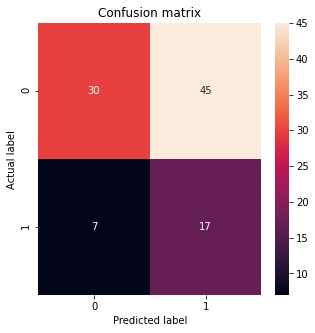

In [122]:
params = {
    'n_estimators':[2, 25, 50, 75, 100],
    'scale_pos_weight': [1,3,9,27,81],
    'learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5],
    'max_depth':[1, 3, 5, 7],
    'min_child_weight':[1, 3, 5, 7],
    'gamma':[0, 0.01, 0.05, 0.1, 0.5, 1, 2, 3],
    'subsample':[0.8],
    'colsample_bynode':[0.7,],
    'colsample_bylevel':[0.9],
    'colsample_bytree':[1],
    
    
}

fit_params_test_score(params,'roc_auc')

### Tuning for accuracy

best params: {'subsample': 0.8, 'scale_pos_weight': 1, 'n_estimators': 75, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 2, 'colsample_bytree': 1, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9}


best score: 0.7838246409674982


Accuracy: 0.6767676767676768
Precission: 0.16666666666666666
Recall: 0.08333333333333333
f1_score: 0.1111111111111111
roc_auc_score: 0.475


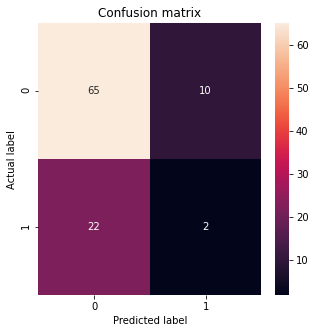

In [183]:
params = {
    'n_estimators':[2, 25, 50, 75, 100],
    'scale_pos_weight': [1,3,9,27,81],
    'learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5],
    'max_depth':[1, 3, 5, 7],
    'min_child_weight':[1, 3, 5, 7],
    'gamma':[0, 0.01, 0.05, 0.1, 0.5, 1, 2, 3],
    'subsample':[0.8],
    'colsample_bynode':[0.7,],
    'colsample_bylevel':[0.9],
    'colsample_bytree':[1],
    
    
}

fit_params_test_score(params,'accuracy')

best params: {'subsample': 0.8, 'scale_pos_weight': 1, 'n_estimators': 50, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.1}


best score: 0.7532811104239676


Accuracy: 0.696969696969697
Precission: 0.2
Recall: 0.08333333333333333
f1_score: 0.11764705882352941
roc_auc_score: 0.4883333333333333


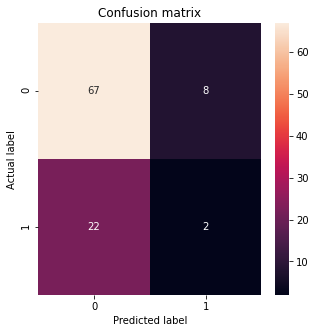

In [187]:

params = {
    'n_estimators':[50],
    'scale_pos_weight': [1],
    'learning_rate':[0.1],
    'max_depth':[2],
    'min_child_weight':[5],
    'subsample':[0.8],
    
}


fit_params_test_score(params,'accuracy')

# Final Pipeline END-to-END

**As neural netwroks are giving slightly better result with accuracy final pipeline is built with NNs**

> Used sklearn tranformers to transform the data and searialized them to disk to use it in the final test script (Like productinizing the model to use on different data along with preprocessing)

## Transform Numerical data

In [130]:
float_cols = list(df.select_dtypes(include='float64').columns)
cat_cols = list(df.select_dtypes(include='int64').columns)
cat_cols.remove('original_shape_VoxelVolume')
cat_cols.remove('pCR (outcome)')
float_cols.append('original_shape_VoxelVolume')
float_cols.remove('RelapseFreeSurvival (outcome)')
df_floats = df[float_cols]
df_cats = df[cat_cols]

### Remove outliers

In [132]:
def find_boundaries(df, variable, distance=1.5):
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
    lower_boundary = df[variable].quantile(0.25) - (IQR * 1.5)
    upper_boundary = df[variable].quantile(0.75) + (IQR * 1.5)
    return lower_boundary, upper_boundary

def treat_outliers(df, variable, distance=1.5, inplace=True):
    """ 
    Fill outliers with mean
    
    upper_boundary = 75th qualtile + (IQR * diatance)
    upper_boundary = 25th qualtile - (IQR * diatance)
        
    """
    
    lower_boundary, upper_boundary = find_boundaries(df,variable)
    if inplace:
        df[variable] = np.where(df[variable]>upper_boundary,df[variable].mean(),
                                np.where(df[variable]<lower_boundary,df[variable].mean(),df[variable])
                           )
    else:
        return np.where(df[variable]>upper_boundary,df[variable].mean(),
                                np.where(df[variable]<lower_boundary,df[variable].mean(),df[variable])
                           )

In [137]:
for col in float_cols:
    treat_outliers(df_floats, col, inplace=True)

### Merging floats and categirical variables

In [139]:
X = pd.concat([df_cats.reset_index(drop=True),df_floats.reset_index(drop=True)],axis=1)
y = df['pCR (outcome)']

### Splitting the data

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42,stratify=y)

### Imputing missing values

In [145]:
sif = SimpleImputer(missing_values=999, strategy='mean')
sic = SimpleImputer(missing_values=999, strategy='median')

In [146]:
#Imputing values for continuous data
sic.fit(X_train[cat_cols])
sif.fit(X_train[float_cols])

X_train_cats = pd.DataFrame(sic.transform(X_train[cat_cols]),columns=cat_cols)
X_train_floats = pd.DataFrame(sif.transform(X_train[float_cols]),columns=float_cols)

X_train = pd.concat([X_train_cats.reset_index(drop=True),X_train_floats.reset_index(drop=True)],axis=1)

X_test_cats = pd.DataFrame(sic.transform(X_test[cat_cols]),columns=cat_cols)
X_test_floats = pd.DataFrame(sif.transform(X_test[float_cols]),columns=float_cols)

X_test = pd.concat([X_test_cats.reset_index(drop=True),X_test_floats.reset_index(drop=True)],axis=1)

### Normalization

In [148]:
transformer = PowerTransformer(method='yeo-johnson')
transformer.fit(X_train[float_cols])
X_train_floats = pd.DataFrame(transformer.transform(X_train[float_cols]),columns=float_cols)
X_test_floats = pd.DataFrame(transformer.transform(X_test[float_cols]),columns=float_cols)

X_train_cats = X_train[cat_cols]
X_test_cats = X_test[cat_cols]

X_train = pd.concat([X_train_cats.reset_index(drop=True),X_train_floats.reset_index(drop=True)],axis=1)
X_test = pd.concat([X_test_cats.reset_index(drop=True),X_test_floats.reset_index(drop=True)],axis=1)

### Scaling the data

In [150]:
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

## Applyting Neural Netwrok

In [154]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


In [155]:
def plot_metrics(history):
  metrics = ['loss', 'accuracy', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    """
    if metric == 'loss':
      #plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])
    """

    plt.legend()

In [156]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

In [157]:
## Run the model with training data and generate metrics on test data

def experiment(model, EPOCHS = 100, PATIENCE=10, lr = 1e-3 ,class_weight={0:1, 1:1}):
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=PATIENCE,
    mode='max',
    restore_best_weights=True)
    
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=METRICS
        )
    baseline_history = model.fit( X_train, y_train, epochs=EPOCHS,callbacks=[early_stopping],
                                 validation_data=(X_test, y_test), verbose=0,
                                 class_weight=class_weight
                                )
    plot_metrics(baseline_history)
    
    test_predictions_baseline = model.predict(X_test)
    
    baseline_results = model.evaluate(X_test, y_test, verbose=0)
    for name, value in zip(model.metrics_names, baseline_results):
        print(name, ': ', value)
        print()
        
    plot_cm(y_test, test_predictions_baseline)
    

In [169]:
## Run the model with training synthetic data and generate metrics on test data
def experimentSD(model, EPOCHS = 100, PATIENCE=10, lr = 1e-3 ):
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=PATIENCE,
    mode='max',
    restore_best_weights=True)
    
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=METRICS
        )
    baseline_history = model.fit( X_res, y_res, epochs=EPOCHS,callbacks=[early_stopping],
                                 validation_data=(X_test, y_test), verbose=0
                                )
    plot_metrics(baseline_history)
    
    test_predictions_baseline = model.predict(X_test)
    
    baseline_results = model.evaluate(X_test, y_test, verbose=0)
    for name, value in zip(model.metrics_names, baseline_results):
        print(name, ': ', value)
        print()
        
    plot_cm(y_test, test_predictions_baseline)
    

### Experiment 1

Restoring model weights from the end of the best epoch: 27.
Epoch 127: early stopping
4/4 [==============================] - 0s 5ms/step
loss :  0.5922486782073975

tp :  2.0

fp :  0.0

tn :  75.0

fn :  22.0

accuracy :  0.7777777910232544

precision :  1.0

recall :  0.0833333358168602

auc :  0.5925000309944153

prc :  0.37854862213134766



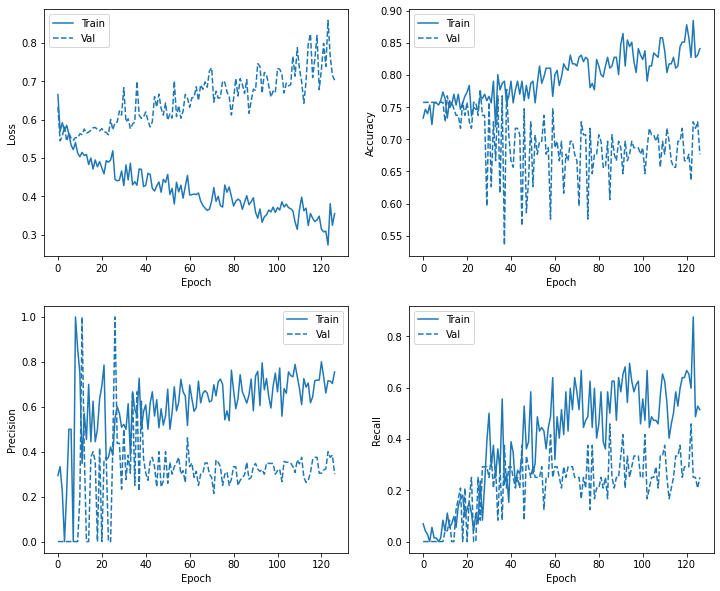

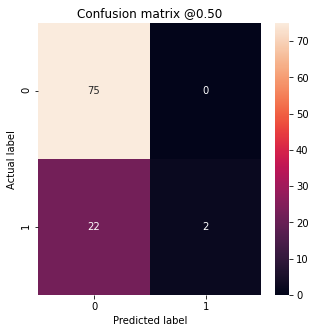

In [160]:
model = keras.Sequential([
      keras.layers.Dense(500, activation='relu',input_shape=(X_train.shape[-1],)),
      keras.layers.Dropout(0.6),
      keras.layers.Dense(800, activation='relu'),
      keras.layers.Dropout(0.6),
      keras.layers.Dense(900, activation='relu'),
      keras.layers.Dropout(0.6),
      keras.layers.Dense(500, activation='relu'),
      keras.layers.Dropout(0.6),
      keras.layers.Dense(200, activation='relu'),
      keras.layers.Dense(1, activation='sigmoid')
  ])

experiment(model, EPOCHS = 300, PATIENCE=100, lr = 1e-2)

### Experiment 2 --- Best

Restoring model weights from the end of the best epoch: 23.
Epoch 123: early stopping
4/4 [==============================] - 0s 4ms/step
loss :  0.7905004620552063

tp :  3.0

fp :  1.0

tn :  74.0

fn :  21.0

accuracy :  0.7777777910232544

precision :  0.75

recall :  0.125

auc :  0.5913887619972229

prc :  0.3568735420703888



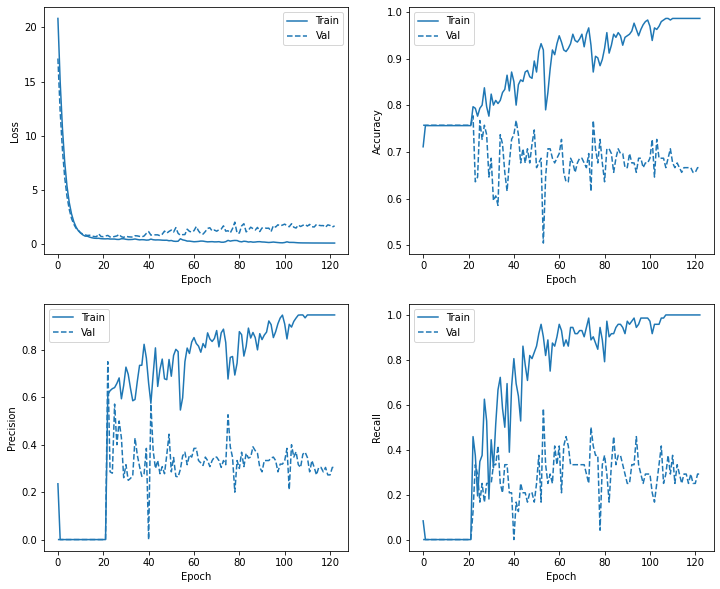

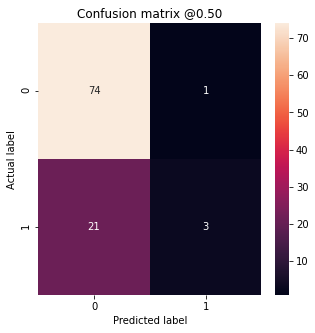

In [161]:
model = keras.Sequential([
      keras.layers.Dense(170, activation='relu',input_shape=(X_train.shape[-1],)),    
      keras.layers.Dense(units = 240, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.02)),  
      keras.layers.Dense(units = 320, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.02)),  
      keras.layers.Dense(units = 480, activation = 'relu'),  
      keras.layers.Dropout(0.1),
      keras.layers.Dense(units = 560, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.02)),  
      keras.layers.Dense(units = 240, activation = 'relu'),
      keras.layers.Dropout(0.1),
      keras.layers.Dense(units = 120, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.02)),  
      keras.layers.Dense(units = 24, activation = 'relu'),
      keras.layers.Dense(1, activation='sigmoid')
  ])

experiment(model,EPOCHS = 500, PATIENCE=100, lr = 1e-4)

### Adding synthetic data

- Used SMOTE to upsmaple the minority class

In [178]:
sm = SMOTE(random_state=42,k_neighbors=3)

X_res, y_res = sm.fit_resample(X_train, y_train)

Restoring model weights from the end of the best epoch: 61.
Epoch 161: early stopping
4/4 [==============================] - 0s 3ms/step
loss :  10.138466835021973

tp :  6.0

fp :  8.0

tn :  67.0

fn :  18.0

accuracy :  0.7373737096786499

precision :  0.4285714328289032

recall :  0.25

auc :  0.6058332324028015

prc :  0.3454113304615021



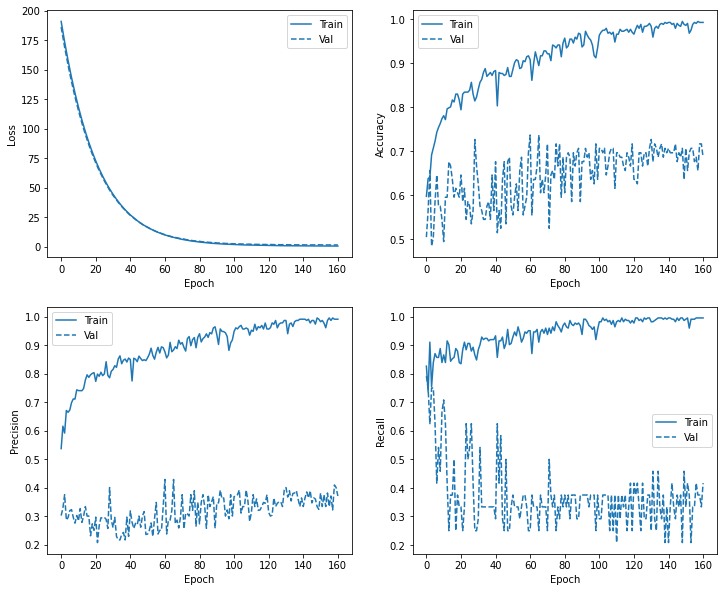

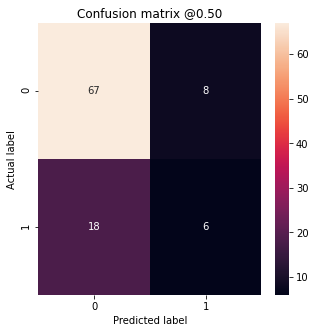

In [182]:
model = keras.Sequential([
      keras.layers.Dense(170, activation='relu',input_shape=(X_train.shape[-1],)),    
      keras.layers.Dense(units = 240, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.1)),  
      keras.layers.Dense(units = 320, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.2)),  
      keras.layers.Dense(units = 480, activation = 'relu'),  
      keras.layers.Dense(units = 560, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.2)),  
      keras.layers.Dense(units = 240, activation = 'relu'),
      keras.layers.Dense(units = 120, activation = 'relu', kernel_regularizer = keras.regularizers.l2(0.1)),  
      keras.layers.Dense(units = 24, activation = 'relu'),
      keras.layers.Dense(1, activation='sigmoid')
  ])

experimentSD(model,EPOCHS = 500, PATIENCE=100, lr = 1e-4)

### Saving all Modle objects to run on the test data

In [ ]:
##Saving the model
model.save('saved_model/best_model_aucc82')

In [ ]:
import pickle

# save the imputer to disk
filename = 'saved_model/float_cols_imputer.sav'
pickle.dump(sif, open(filename, 'wb'))

filename = 'saved_model/int_cols_imputer.sav'
pickle.dump(sic, open(filename, 'wb'))

# save the transformer to disk
filename = 'saved_model/trnsformer.sav'
pickle.dump(transformer, open(filename, 'wb'))


# save the scaler to disk
filename = 'saved_model/scaler.sav'
pickle.dump(scaler, open(filename, 'wb'))

# Continuous columns list
filename = 'saved_model/continuous_features.pkl'
pickle.dump({'continuous_features':float_cols}, open(filename, 'wb'))

# Categorical columns
filename = 'saved_model/categorical_features.pkl'
pickle.dump({'categorical_features':cat_cols}, open(filename, 'wb'))


## Conclusion

**The main problem with this dataset for not giving better accuracy is , data is not seperable, data from both classes randomly mixed in the sample space**

Below plot is generated by reducing the dimentions to 2 using feature importance method of tree based algorithm and using 2 feature whih catcher highest varience in the target variabel


This clearly shown this data seems random with no clear pattern of seperation netween classes

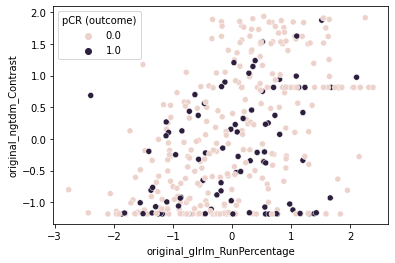

In [119]:
sns.scatterplot(x=final_continuous_features_df['original_glrlm_RunPercentage'],
                y=final_continuous_features_df['original_ngtdm_Contrast'],
                hue=df['pCR (outcome)']
               )
plt.show()